# Import

In [1]:
import pandas as pd
import gtfs_kit as gk
import warnings
import helper
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import LabelEncoder
from scipy.stats import pointbiserialr

from sklearn.ensemble import RandomForestClassifier
import joblib

warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

# Load Datasets

In [2]:
# Load the gtfs we generated with the various csv file created in the preprocessing
feed = gk.feed.read_feed('../processed_files/preprocessing_gtfs_static.zip',dist_units="km")
stop_times = feed.get_stop_times()
gtfs_static_stats = stop_times.copy()

# Load complete gtfs static - delays and weather dataset
main_dataset = pd.read_csv("../processed_files/df_linea.csv", index_col=[0])
main_dataset = main_dataset.assign(isArrivoRitardo=None)
main_dataset = main_dataset.assign(isPartenzaRitardo=None)

In [3]:
for index,row in main_dataset.iterrows():
    if (row['ritardo_arrivo'] >= 2):
        main_dataset.loc[index,'isArrivoRitardo'] = 1
    else:
        main_dataset.loc[index,'isArrivoRitardo'] = 0
    if (row['ritardo_partenza'] >= 2):
        main_dataset.loc[index,'isPartenzaRitardo'] = 1
    else:
        main_dataset.loc[index,'isPartenzaRitardo'] = 0

In [4]:
#Drop Columns
#main_dataset = main_dataset.drop(['ritardo_arrivo'], axis=1)

# Basic - Statistics

In [5]:
gtfs_static_stats.describe()

,stop_sequence,shape_dist_traveled,time_diff,speed,dist_diff
count,12393.000000,12393.000000,12393.000000,12393.000000,12393.000000
mean,8.228435,34.291976,0.085722,48.500238,4.489057
std,6.335342,28.304966,0.048770,21.100640,2.721408
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,11.707840,0.066667,39.346200,2.623080
50%,6.000000,23.531950,0.083333,52.007100,3.853210
75%,13.000000,54.633010,0.116667,62.004300,6.343740
max,28.000000,113.447760,0.433333,100.352914,24.186790


## Stops

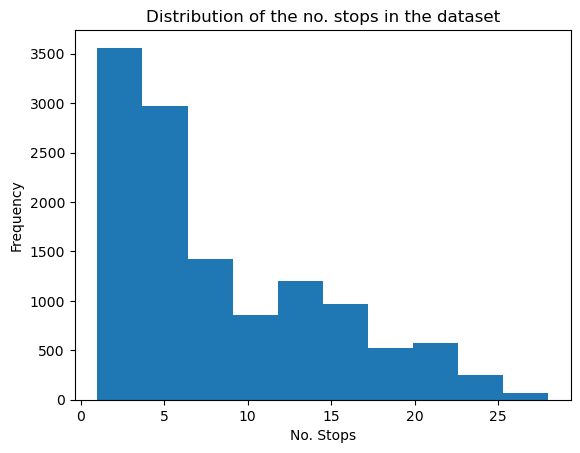

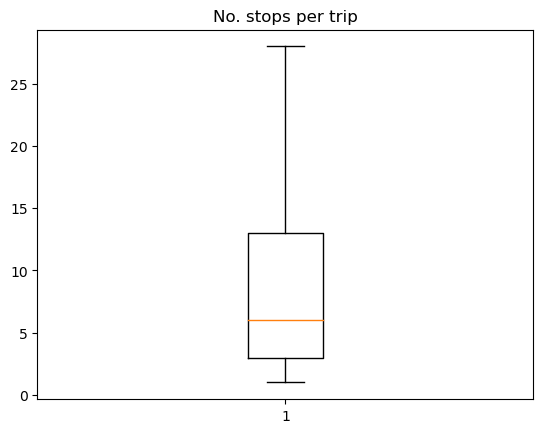

In [6]:
# Distribution of number of stops in the dataset
plt.title('Distribution of the no. stops in the dataset')
plt.hist(gtfs_static_stats.stop_sequence)
plt.xlabel('No. Stops')
plt.ylabel('Frequency')
plt.savefig('../images/data_analytics_images/stop_sequence_gtfs_static_statistics.png')
plt.show()
# Box Plot
plt.boxplot(gtfs_static_stats.stop_sequence)
plt.title('No. stops per trip')
plt.savefig('../images/data_analytics_images/stop_sequence_gtfs_static_box_plot.png')
plt.show()

In [7]:
# Analytics on number of stop per trip
result = helper.calculate_stops(gtfs_static_stats)
result.head(30)

,last_stop_sequence,value
0,1,0
1,2,0
2,3,6
3,4,16
4,5,579
5,6,93
6,7,24
7,8,48
8,9,8
9,10,0


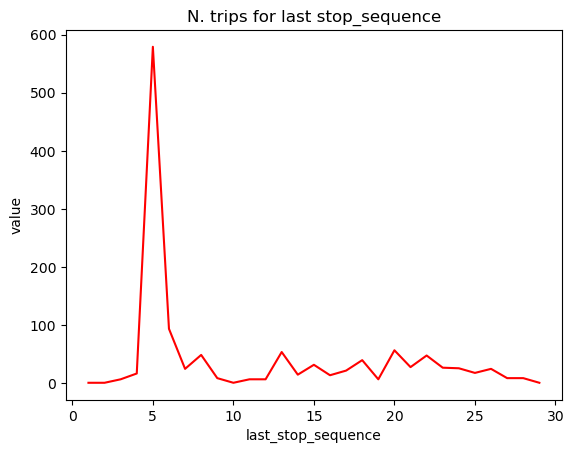

In [8]:
plt.title('N. trips for last stop_sequence')
# Plot total 
plt.plot(result['last_stop_sequence'], result['value'], color='r')
plt.xlabel('last_stop_sequence')
plt.ylabel('value')
plt.savefig('../images/data_analytics_images/number_stops_gtfs_static_plot.png')
plt.show()

## Time

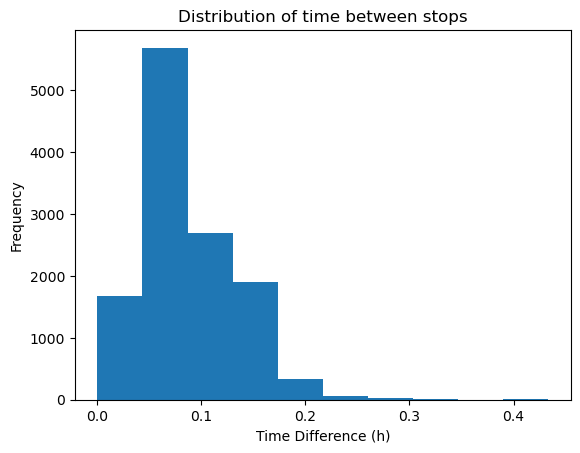

In [9]:
# Distribution of time in the dataset
plt.title('Distribution of time between stops')
plt.hist(gtfs_static_stats.time_diff)
plt.xlabel('Time Difference (h)')
plt.ylabel('Frequency')
plt.savefig('../images/data_analytics_images/time_gtfs_static_plot.png')
plt.show()

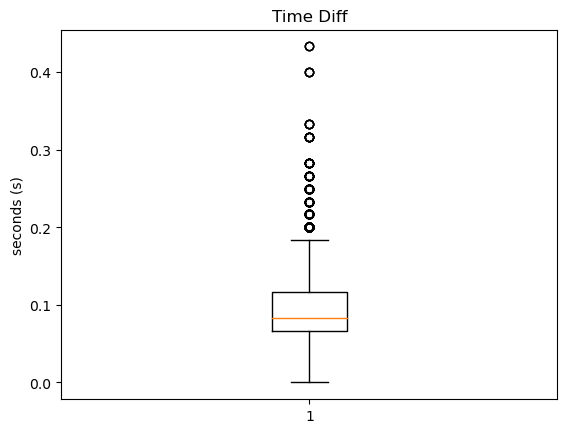

In [10]:
plt.boxplot(gtfs_static_stats.time_diff)
plt.title('Time Diff')
plt.ylabel("seconds (s)")
plt.savefig('../images/data_analytics_images/time_gtfs_static_box_plot.png')
plt.show()

## Distance

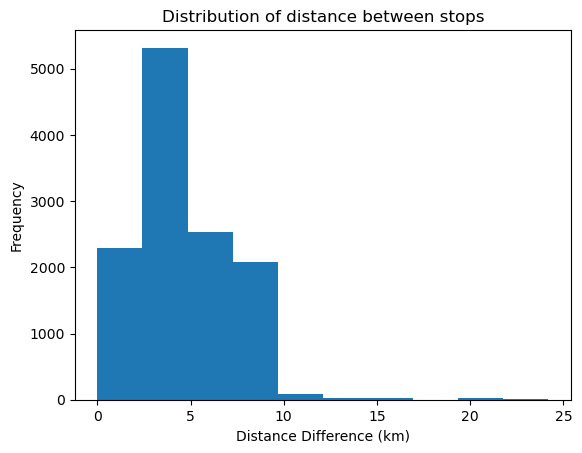

In [11]:
# Distribution of distance in the dataset
plt.title('Distribution of distance between stops')
plt.hist(gtfs_static_stats.dist_diff)
plt.xlabel('Distance Difference (km)')
plt.ylabel('Frequency')
plt.savefig('../images/data_analytics_images/distance_gtfs_static_plot.png')
plt.show()

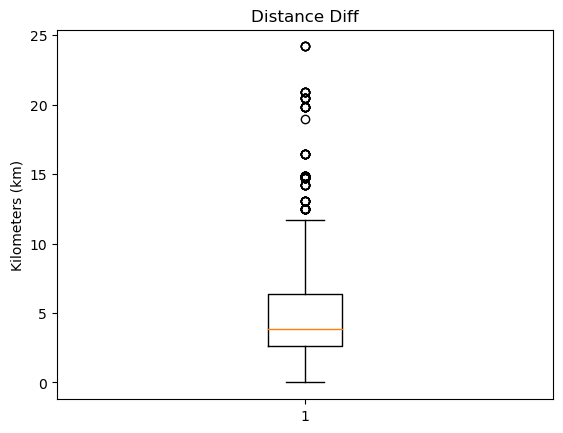

In [12]:
plt.boxplot(gtfs_static_stats.dist_diff)
plt.title('Distance Diff')
plt.ylabel("Kilometers (km)")
plt.savefig('../images/data_analytics_images/distance_gtfs_static_box_plot.png')
plt.show()

## Speed

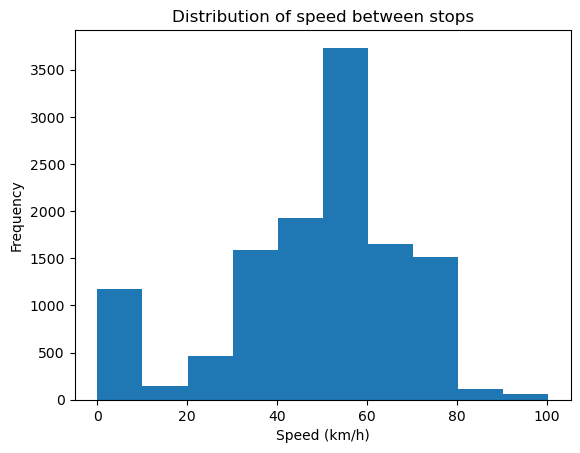

In [13]:
# Distribution of number of stops in the dataset
plt.title('Distribution of speed between stops')
plt.hist(gtfs_static_stats.speed)
plt.xlabel('Speed (km/h)')
plt.ylabel('Frequency')
plt.savefig('../images/data_analytics_images/speed_gtfs_static_plot.png')
plt.show()

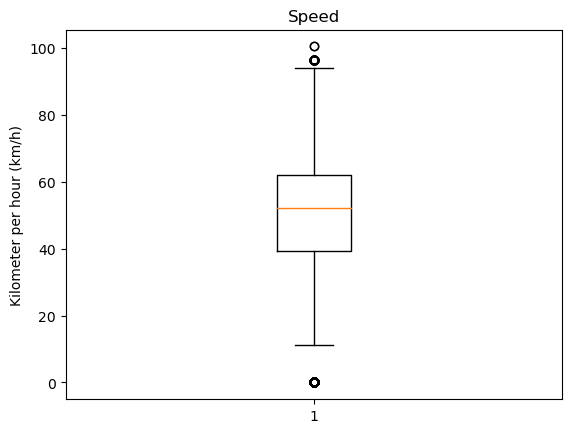

In [14]:
plt.boxplot(gtfs_static_stats.speed)
plt.title('Speed')
plt.ylabel("Kilometer per hour (km/h)")
plt.savefig('../images/data_analytics_images/speed_gtfs_static_box_plot.png')
plt.show()


## Corr Speed Time and Distance

In [15]:
df_corr = helper.dataset_for_scatter(stop_times)


/Users/gianlucarea/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


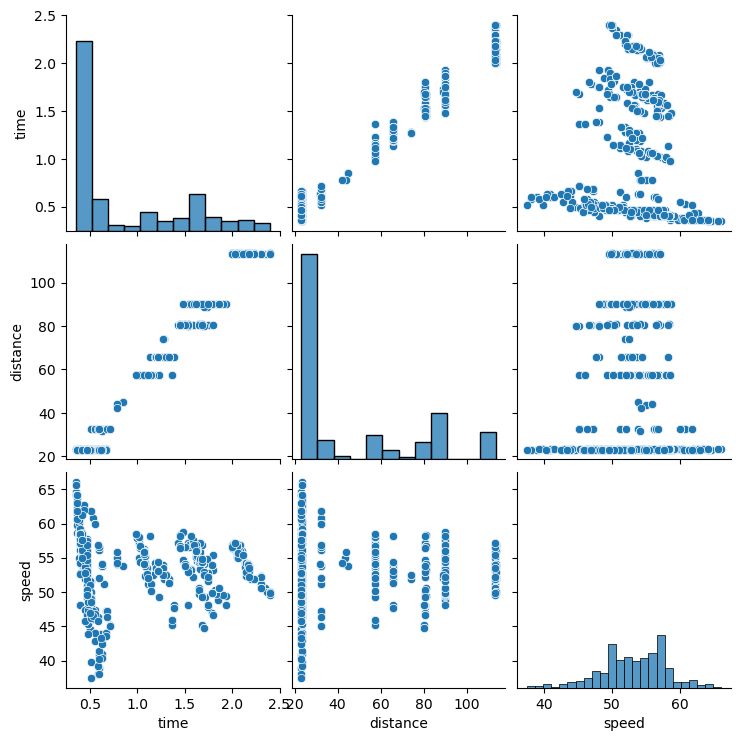

In [16]:
helper.correlogram_time_distance_speed(df_corr)

## Year Analytics

In [17]:
year_stats = helper.select_year_df('20210103','20220102')

In [18]:
year_stats = year_stats.groupby(['trip_id','service_id','date']).max('stop_sequence').reset_index()
week_division_dates = helper.calendar_2021()

result = pd.DataFrame(columns=['corse_totali', 'corse_veloci', 'corse_medie', 'corse_lente'], index=range(len(week_division_dates)-1)).fillna(0)
result.index += 1

#REGOLARE NUMERI CLUSTERING (Veloci , Medi, Lenti)
for i in range(len(week_division_dates)-1):
    ## Collecting all service date of trips on those days
    temp_analytics = year_stats.loc[(year_stats['date'] >= week_division_dates[i]) &
                                       (year_stats['date'] < week_division_dates[i+1])]
    for index, row  in temp_analytics.iterrows():
        result.at[i+1,'corse_totali'] += 1
        if(row.stop_sequence <= 5):
            result.at[i+1,'corse_veloci'] += 1
        if(row.stop_sequence > 5 and row.stop_sequence <= 10):
            result.at[i+1,'corse_medie'] += 1
        if(row.stop_sequence > 10):
            result.at[i+1,'corse_lente'] += 1

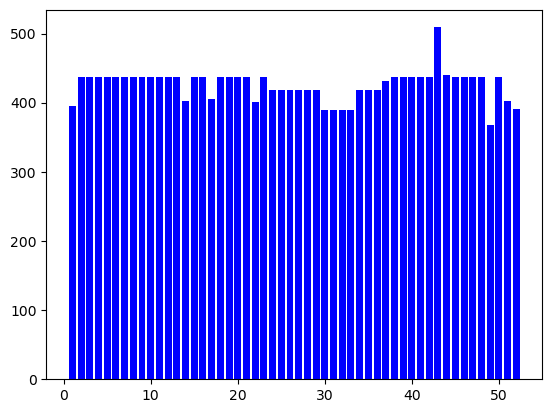

In [19]:
# Plot total 
plt.bar(result.index, result['corse_totali'], color='b')
plt.show()

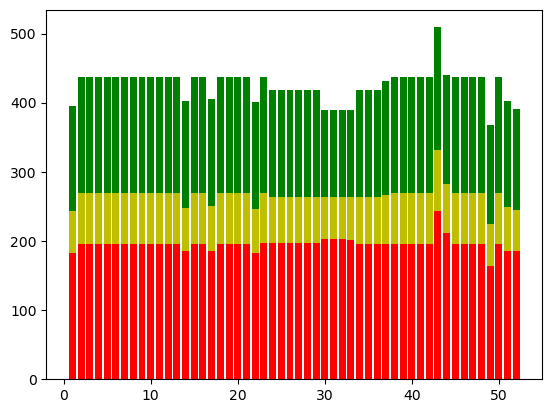

In [20]:
plt.bar(result.index, result['corse_veloci'], color='r')
plt.bar(result.index, result['corse_medie'], bottom=result['corse_veloci'], color='y')
plt.bar(result.index, result['corse_lente'],bottom=result['corse_veloci']+result['corse_medie'], color='g')
plt.show()


# Advanced - Statistics


In [21]:
main_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 251059 entries, 0 to 251058
Data columns (total 33 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   trip_id                 251059 non-null  object 
 1   arrival_time            251059 non-null  int64  
 2   departure_time          251059 non-null  int64  
 3   codice_stazione_p       251059 non-null  object 
 4   codice_stazione_a       251059 non-null  object 
 5   indice_tratta           251059 non-null  int64  
 6   shape_dist_traveled     251059 non-null  float64
 7   time_diff               251059 non-null  float64
 8   speed                   251059 non-null  float64
 9   dist_diff               251059 non-null  float64
 10  codice                  251059 non-null  int64  
 11  direction_id            251059 non-null  int64  
 12  data_giorno             251059 non-null  int64  
 13  stop_code_p             251059 non-null  int64  
 14  stop_code_a             2

main_dataset = main_dataset.round({'temperature':0,'speed':0,'wind_speed':0,'temperature_linea':0,
                                  'app_temp_linea':0,'wind_dir_10m_linea':0,'soil_temperature_linea':0 ,
                                  'wind_gusts_linea':0, 'wind_dir_100m_linea':0 ,'wind_speed_100m_linea':0,
                                  'wind_speed_10m_linea':0, 'wmo_code_linea':0 , 'humidity_linea':0}) 

In [22]:
main_dataset = main_dataset.round({'speed':0,'temperature_linea':0,'wind_dir_10m_linea':0,'soil_temperature_linea':0 ,
                                  'wind_gusts_linea':0, 'wind_dir_100m_linea':0 ,'wind_speed_100m_linea':0,
                                  'wind_speed_10m_linea':0, 'wmo_code_linea':0 , 'humidity_linea':0}) 

#Point Biserial Correlation 
#encode categorical data into numeric values
labelEncoder = LabelEncoder()
main_dataset["trip_id"] = labelEncoder.fit_transform(main_dataset["trip_id"])
main_dataset["codice_stazione"] = labelEncoder.fit_transform(main_dataset["codice_stazione"])
main_dataset["orario_arrivo"] = labelEncoder.fit_transform(main_dataset["orario_arrivo"])
main_dataset["orario_partenza"] = labelEncoder.fit_transform(main_dataset["orario_partenza"])
main_dataset["orario"] = labelEncoder.fit_transform(main_dataset["orario"])
main_dataset["time"] = labelEncoder.fit_transform(main_dataset["time"])

#get continuous and dichotomous data
categorical = ["trip_id", "arrival_time", "departure_time", "codice_stazione", "stop_sequence",
               "shape_dist_traveled", "time_diff","speed","dist_diff","codice","direction_id",
               "data_giorno","stop_lat","stop_lon","stop_code","ritardo_partenza",
               "orario_arrivo","orario_partenza",
               "orario","location_id","time","temperature","humidity","app_temp","precipitation",
               "rain","snow_fall","snow_depth","wmo_code","wind_speed_10m","wind_speed_100m",
               "wind_dir_10m","wind_dir_100m","wind_gusts","soil_temperature",
               "temperature_linea","humidity_linea","app_temp_linea","precipitation_linea",
               "rain_linea","snow_fall_linea","snow_depth_linea","wmo_code_linea","wind_speed_10m_linea",
               "wind_speed_100m_linea","wind_dir_10m_linea","wind_dir_100m_linea","wind_gusts_linea",
               "soil_temperature_linea","isPartenzaRitardo","isArrivoRitardo"]
numeric = ["arrival_time", "departure_time","stop_sequence",
               "shape_dist_traveled", "time_diff","speed","dist_diff","codice","direction_id",
               "data_giorno","stop_lat","stop_lon","stop_code","ritardo_partenza",
               "location_id","temperature","humidity","app_temp","precipitation",
               "rain","snow_fall","snow_depth","wmo_code","wind_speed_10m","wind_speed_100m",
               "wind_dir_10m","wind_dir_100m","wind_gusts","soil_temperature",
               "temperature_linea","humidity_linea","app_temp_linea","precipitation_linea",
               "rain_linea","snow_fall_linea","snow_depth_linea","wmo_code_linea","wind_speed_10m_linea",
               "wind_speed_100m_linea","wind_dir_10m_linea","wind_dir_100m_linea","wind_gusts_linea",
               "soil_temperature_linea","isPartenzaRitardo","isArrivoRitardo"]
target = main_dataset["isArrivoRitardo"]

#pbc of first question
pbc = list()
for col in numeric:
    ans = pointbiserialr(main_dataset[col], target)
    pbc.append([col, ans[0], ans[1]])
    
pbc_corr = pd.DataFrame(pbc, columns=["Feature", "CorrCoeff", "pValue"]).sort_values(by="CorrCoeff", ascending=False).reset_index(drop=True)
pbc_corr

In [23]:
# Point Biserial Correlation 
# encode categorical data into numeric values
labelEncoder = LabelEncoder()
main_dataset["trip_id"] = labelEncoder.fit_transform(main_dataset["trip_id"])
main_dataset["codice_stazione_p"] = labelEncoder.fit_transform(main_dataset["codice_stazione_p"])
main_dataset["codice_stazione_a"] = labelEncoder.fit_transform(main_dataset["codice_stazione_a"])

# get continuous and dichotomous data
categorical = ['trip_id','arrival_time','departure_time','codice_stazione_p',
               'codice_stazione_a','indice_tratta','shape_dist_traveled','time_diff',
               'speed','dist_diff','codice','direction_id','data_giorno','stop_code_p',
               'stop_code_a','ritardo_partenza','ritardo_arrivo','temperature_linea',
               'app_temp_linea','rain_linea','snow_fall_linea','snow_depth_linea','humidity_linea',
               'precipitation_linea','wmo_code_linea','wind_speed_10m_linea','wind_speed_100m_linea',
               'wind_dir_10m_linea','wind_dir_100m_linea','wind_gusts_linea','soil_temperature_linea',
               'isArrivoRitardo','isPartenzaRitardo'
              ]
numeric = ['trip_id','arrival_time','departure_time','codice_stazione_p',
           'codice_stazione_a','indice_tratta','shape_dist_traveled','time_diff',
           'speed','dist_diff','codice','direction_id','data_giorno','stop_code_p',
           'stop_code_a','ritardo_partenza','ritardo_arrivo','temperature_linea',
           'app_temp_linea','rain_linea','snow_fall_linea','snow_depth_linea','humidity_linea',
           'precipitation_linea','wmo_code_linea','wind_speed_10m_linea','wind_speed_100m_linea',
           'wind_dir_10m_linea','wind_dir_100m_linea','wind_gusts_linea','soil_temperature_linea',
           'isArrivoRitardo','isPartenzaRitardo']
target = main_dataset["isArrivoRitardo"]

# pbc of first question
pbc = list()
for col in numeric:
    ans = pointbiserialr(main_dataset[col], target)
    pbc.append([col, ans[0], ans[1]])
    
pbc_corr = pd.DataFrame(pbc, columns=["Feature", "CorrCoeff", "pValue"]).sort_values(by="CorrCoeff", ascending=False).reset_index(drop=True)
pbc_corr

,Feature,CorrCoeff,pValue
0,isArrivoRitardo,1.000000,0.000000e+00
1,isPartenzaRitardo,0.584578,0.000000e+00
2,ritardo_arrivo,0.481714,0.000000e+00
3,ritardo_partenza,0.392568,0.000000e+00
4,codice,0.212778,0.000000e+00
5,indice_tratta,0.167457,0.000000e+00
6,shape_dist_traveled,0.147753,0.000000e+00
7,speed,0.128070,0.000000e+00
8,wmo_code_linea,0.065126,4.660519e-234
9,wind_gusts_linea,0.035956,1.318185e-72


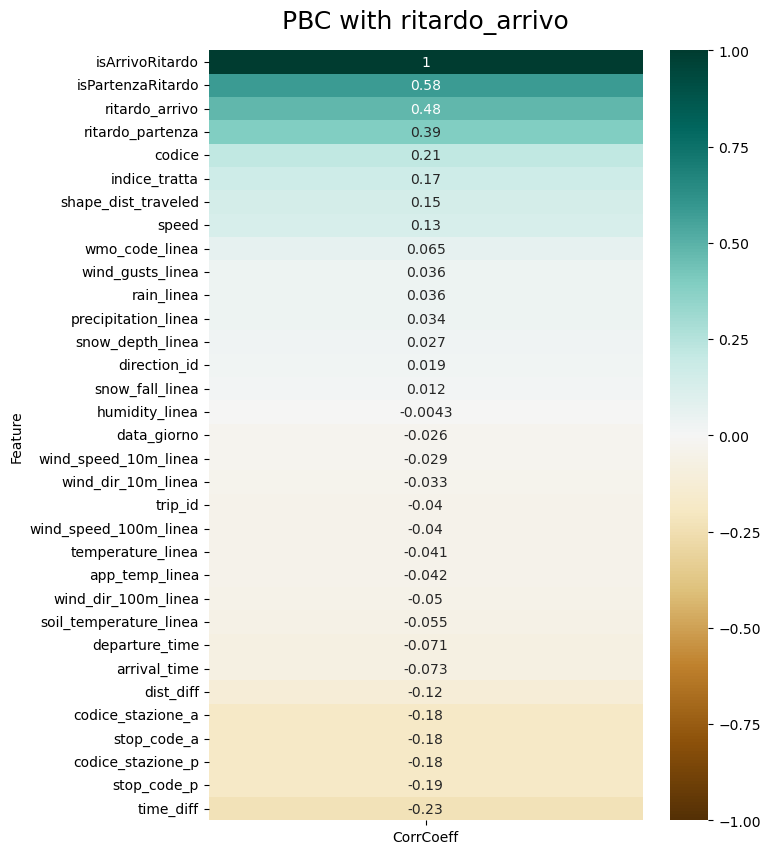

In [24]:
# Point biserial correlation

plt.figure(figsize=(7, 10))
pbc_corr = pbc_corr.set_index("Feature")
heatmap = sns.heatmap(pbc_corr[["CorrCoeff"]].sort_values(by="CorrCoeff", ascending=False), vmin=-1, vmax=1, annot=True, cmap="BrBG")
heatmap.set_title("PBC with ritardo_arrivo", fontdict={"fontsize":18}, pad=16);
plt.savefig("../images/data_analytics_images/pointbiserial_correlation.png")
del pbc_corr

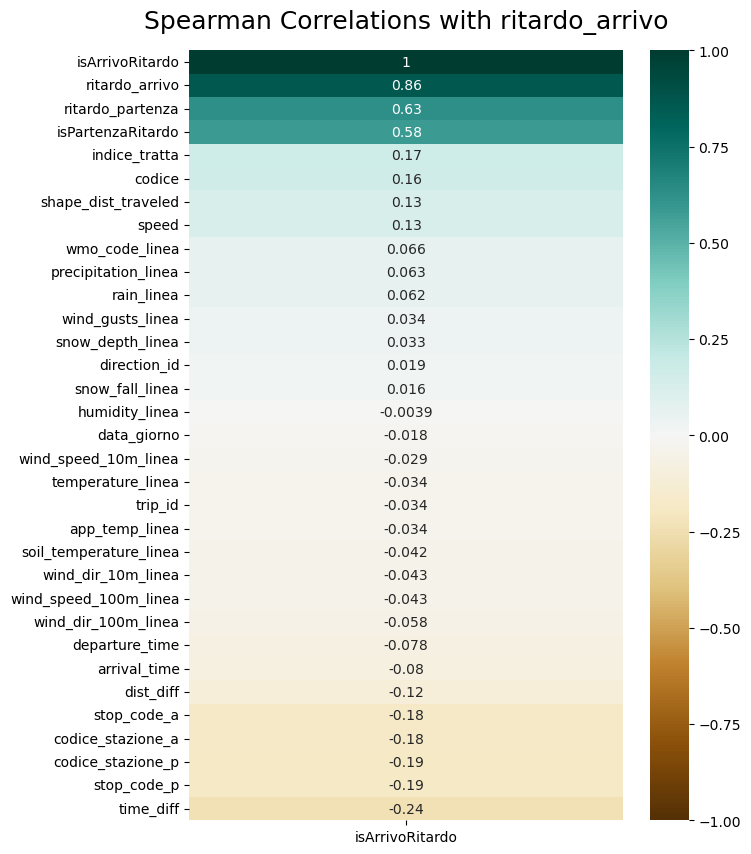

In [25]:
# Spearman correlation
plt.figure(figsize=(7, 10))
heatmap = sns.heatmap(main_dataset[categorical].corr(method="spearman")[["isArrivoRitardo"]].sort_values(by="isArrivoRitardo", ascending=False), vmin=-1, vmax=1, annot=True, cmap="BrBG")
heatmap.set_title("Spearman Correlations with ritardo_arrivo", fontdict={"fontsize":18}, pad=16)
plt.savefig("../images/data_analytics_images/spearman_correlation.png")
del heatmap

In [26]:
#Drop Columns
main_dataset_dropped = main_dataset.drop(['codice_stazione_p','codice_stazione_a'], axis=1)

In [27]:
main_dataset_dropped["isArrivoRitardo"] = main_dataset_dropped["isArrivoRitardo"].astype(float)
main_dataset_dropped["isPartenzaRitardo"] = main_dataset_dropped["isPartenzaRitardo"].astype(float)

In [28]:
X = main_dataset_dropped.loc[:, main_dataset_dropped.columns != "isArrivoRitardo"]
y = np.array(main_dataset_dropped.loc[:, main_dataset_dropped.columns == "isArrivoRitardo"]["isArrivoRitardo"])

model = RandomForestClassifier(n_estimators=100,
                       criterion="entropy", random_state=42, n_jobs=-1)

model.fit(X, y)

joblib.dump(model, "./Data/feature_importance_model.joblib")
model = joblib.load("./Data/feature_importance_model.joblib")
importances = model.feature_importances_
importances

array([1.23010614e-03, 4.89544213e-03, 4.69681445e-03, 8.01013088e-03,
       8.88745392e-03, 1.51334648e-02, 1.55092471e-02, 8.19052488e-03,
       1.02479262e-02, 7.77264149e-04, 1.85454088e-03, 1.10893953e-02,
       1.36289791e-02, 1.28320532e-01, 6.71007220e-01, 9.77095631e-04,
       1.37279657e-03, 3.23515331e-04, 9.01105812e-06, 6.13919232e-05,
       1.18951968e-03, 3.24764000e-04, 5.29737271e-04, 7.62877889e-04,
       8.97256814e-04, 1.27877645e-03, 1.25342068e-03, 1.01062373e-03,
       1.18923828e-03, 8.53409331e-02])

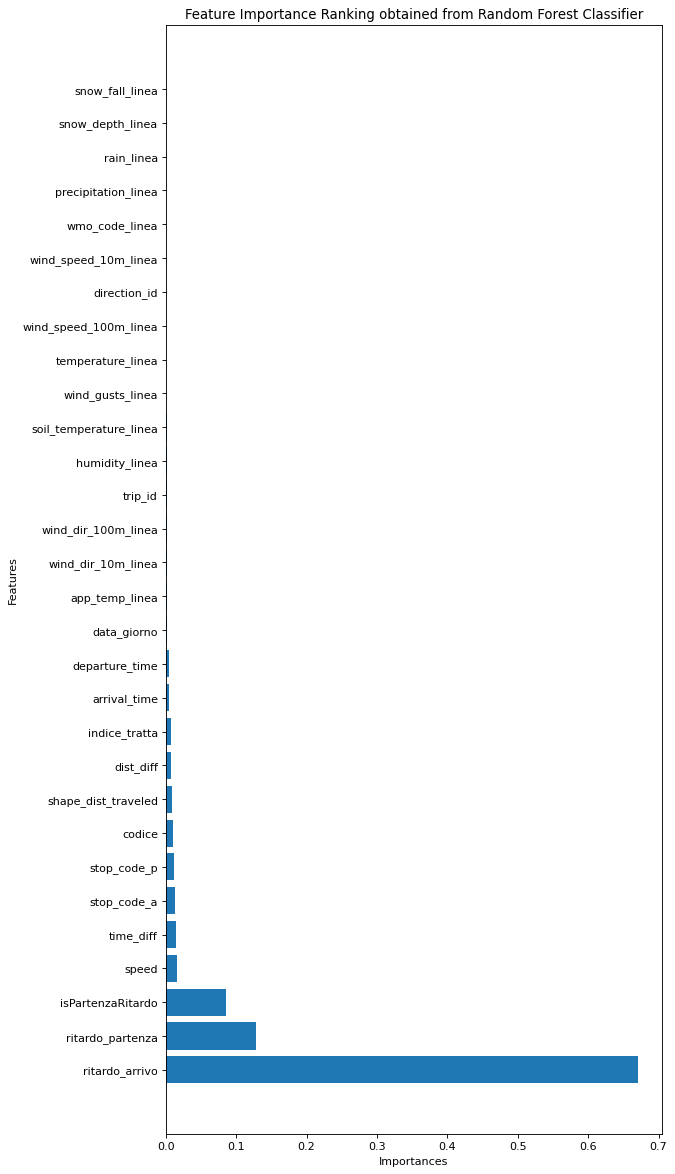

In [29]:
importances = pd.DataFrame({
    "Feature": list(X.columns),
    "Importance": model.feature_importances_
})
importances = importances.sort_values(by="Importance", ascending=False)
importances = importances.set_index("Feature")
importances
plt.figure(figsize=(8, 18), dpi=80)
plt.barh(importances.index, importances.Importance)
plt.title("Feature Importance Ranking obtained from Random Forest Classifier", fontsize=12)
plt.xlabel("Importances")
plt.ylabel("Features")
plt.savefig("../images/data_analytics_images/Feature_Importances_stat.png")

# Balance of the Dataset 

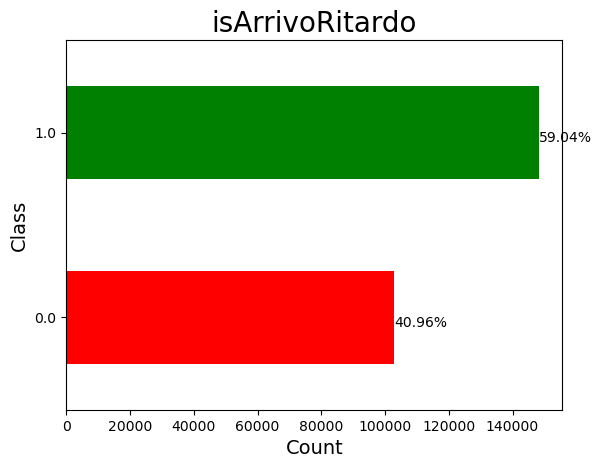

isArrivoRitardo
1.0    148230
0.0    102829
Name: count, dtype: int64


In [30]:
# Plotting the percentage of observations that fall under each class
ax = main_dataset_dropped["isArrivoRitardo"].value_counts().sort_values().plot(kind="barh", color=["r", "g"])
totals= []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in ax.patches:
     ax.text(i.get_width()+.3, i.get_y()+.20, 
     str(round((i.get_width()/total)*100, 2))+'%', 
     fontsize=10, color='black')
plt.title("isArrivoRitardo", fontsize=20)
plt.xlabel("Count", fontsize=14)
plt.ylabel("Class", fontsize=14)
plt.show()
print(main_dataset_dropped["isArrivoRitardo"].value_counts())
fig = ax.get_figure()
fig.savefig("../images/data_analytics_images/imbalance.png")

In [31]:
#Save dataset_for_classification
main_dataset_dropped.to_csv('../processed_files/df_for_ml.csv')